In [1]:
import unicodedata
import pandas
import numpy
from main import get_place_data as GetPlaceData
from main.utils.data_logger import Logger
from main.core.data_handler import DataHandler
from main.core.classifier import Recommender
from main.core.make_map import FoliumMap
from main import make_recommendation
import main.utils as utils
map_handler = FoliumMap()
data_handler = DataHandler()
my_logger = Logger(logger_name='Test_run').get_logger()
%reload_ext sql
%sql mysql+pymysql://root:secret@db:3306/my_db

### Getting data from google places API

In [293]:
my_logger = Logger(logger_name='Test_run').get_logger()
my_logger.info('Start')
results = await GetPlaceData.run(query='Sao Paulo, SP', type='restaurant',radius=5000, resolution=50, timeout=20)
my_logger.info('Done!')

In [297]:
data_frame = data_handler.dict_list_to_dataframe(results)
data_frame['name'] = data_frame['name'].apply(lambda name: emoji.demojize(name))
data_frame['name'] = data_frame['name'].apply(lambda name: strip_accents(name))
data_frame['formatted_address'] = data_frame['formatted_address'].apply(lambda name: strip_accents(name))
data_frame['lat'] = data_frame['geometry'].apply(lambda row: row['location']['lat'])
data_frame['lon'] = data_frame['geometry'].apply(lambda row: row['location']['lng'])
data_frame.columns

Index(['business_status', 'formatted_address', 'geometry', 'icon',
       'icon_background_color', 'icon_mask_base_uri', 'name', 'opening_hours',
       'photos', 'place_id', 'plus_code', 'rating', 'reference', 'types',
       'user_ratings_total', 'price_level', 'permanently_closed', 'lat',
       'lon'],
      dtype='object')

### Connecting to db, filtering revelant info and adding it to db.

In [6]:
engine = data_handler.db_connect(db_url = "mysql+pymysql://root:secret@db:3306/my_db")

Connected:
 test_table


In [5]:
data_frame2 = data_frame[['business_status', 'name', 'place_id', 'price_level','lat', 'lon' ,'rating','user_ratings_total']]
data_handler.add_data_to_db(data_frame2, name='RESTAURANT_SP_CAP2',con = engine, if_exists='replace', index=False, method='multi')


NameError: name 'data_frame' is not defined

#### Now quering this data from db, making it to a dataframe, and dropping NaN values.

In [8]:
data_frame = data_handler.get_data_from_db(query="SELECT * FROM RESTAURANT_SP_CAP_2", con=engine)
data_frame.dropna(inplace=True)
data_frame['place_id']=data_frame['place_id'].astype(str)
data_frame['name']=data_frame['name'].astype(str)
#data_frame['formatted_address']=data_frame['formatted_address'].astype(str)
print(data_frame.shape)
data_frame.dtypes

(713, 9)


business_status        object
formatted_address      object
name                   object
place_id               object
price_level           float64
lat                   float64
lon                   float64
rating                float64
user_ratings_total      int64
dtype: object

### Getting only relevant data to classifier

In [9]:
data_frame.drop_duplicates(['place_id'], keep='last', inplace=True)
data_frame.reset_index(drop=True, inplace=True)
data_frame2=data_frame[['price_level', 'rating', 'user_ratings_total', 'lat', 'lon']]
data_frame2.shape




(219, 5)

### Acessing the best k number through elbow method, using Within Cluster Sum of Squared Errors

In [5]:
my_classifier = Recommender()
my_classifier.preprocess(data_frame2, standarize=True)
my_classifier.get_best_cluster_number(n_clusters=20,method='ms',init = "k-means++", n_init=12)


Number of estimated clusters MS : 4


### Discovered that the best k is 4.

### Visualising clusters!

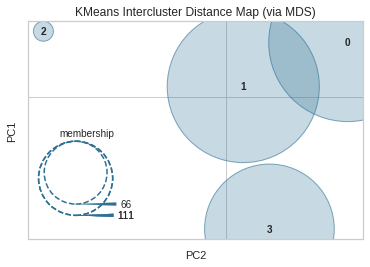

In [6]:
my_classifier.train(n_clusters=4, init = "k-means++", n_init=12)
my_classifier.plot_intercluster_distance()

### Making Predictions for all locations.

In [7]:
result = []
for idx, row in data_frame2.iterrows():
   result.append([idx,my_classifier.predict_over_a_dataset(row)[0]])

data_frame['id'] = data_frame.index
result_series = pandas.DataFrame(result)
result_series.rename(columns={0:'id',1:'cluster'}, inplace=True)
final_df = pandas.merge(data_frame, result_series)
final_df.head(5)


,business_status,name,place_id,price_level,lat,lon,rating,user_ratings_total,id,cluster
0,OPERATIONAL,Restaurante Sabor de Minas,ChIJiQSVYZkpzpQRaYfvnZlVWfQ,1.0,-24.128515,-46.689152,4.3,107,0,1
1,OPERATIONAL,Oca Juba Restaurante e Pizzaria,ChIJdRpKCZ3V0ZQRPbJ0FVNdIdI,2.0,-24.184645,-46.785017,4.2,227,1,1
2,OPERATIONAL,Bella Pizza Pizzaria e Restaurante,ChIJEXs7LI8qzpQRR-S3PlHhAiY,2.0,-24.162485,-46.782624,4.2,147,2,1
3,OPERATIONAL,Restaurante do Esquinao,ChIJ_-sHMr0q0JQR_FIDSaHW8OA,2.0,-24.203062,-46.842739,4.2,47,3,1
4,OPERATIONAL,Padaria Lanchonete Restaurante Suarao Itanhaem,ChIJA8K6Tf_V0ZQR0qNk1NE1fXM,2.0,-24.161845,-46.752319,4.3,412,4,1


In [8]:
result_series['cluster'].value_counts()

1    321
Name: cluster, dtype: int64

In [9]:
restaurant = final_df.iloc[0][['price_level', 'rating', 'user_ratings_total', 'lat', 'lon']]
print(restaurant)
cluster = my_classifier.predict_over_a_dataset(restaurant)
best_5_rest = final_df[(final_df['cluster']==cluster[0])].sort_values('rating').iloc[:4]
best_5_rest


price_level                 1.0
rating                      4.3
user_ratings_total          107
lat                  -24.128515
lon                  -46.689152
Name: 0, dtype: object


,business_status,name,place_id,price_level,lat,lon,rating,user_ratings_total,id,cluster
218,OPERATIONAL,Dio Mio Pizzaria e Restaurante,ChIJmYaaRXFnzpQRjKXacbbjAEM,2.0,-23.573197,-46.502378,3.4,157,218,1
305,OPERATIONAL,Restaurante Vem e Ve,ChIJM5SIRGp9zpQRSXUUrhYnJ-Y,1.0,-23.424462,-46.341736,3.9,78,305,1
139,OPERATIONAL,Nova Panela de Ferro Restaurante,ChIJhaI0pFFCzpQRvqc1CFkhjR0,1.0,-23.665617,-46.541376,3.9,225,139,1
130,OPERATIONAL,"Restaurante Universitario, UFABC, Campus Santo...",ChIJx6La6JdCzpQRgSifYZs5KsE,1.0,-23.644852,-46.526032,3.9,452,130,1


In [367]:
locations_df = best_5_rest[['name', 'lat', 'lon','formatted_address']]
marker_locations_df = locations_df.copy()
marker_locations_df['marker_color'] = locations_df['formatted_address'].apply(lambda x: 'green')


my_map3 = FoliumMap()
my_map3.bulk_add_location_to_map(location_dataframe=locations_df, zoom_start=5, circle_color='#000000', marker_color='#d35400')
my_map3.add_marker_cluster(marker_locations_df)
my_map3.show_map()

In [2]:
import pandas
restaurant = {'price_level':[1.0],
              'rating':[4.3],
              'user_ratings_total':[107],
              'lat ':[-24.128515],
              'lon':[-46.689152]}
restaurant = pandas.DataFrame(restaurant)
restaurant

,price_level,rating,user_ratings_total,lat,lon
0,1.0,4.3,107,-24.128515,-46.689152


In [3]:
make_recommendation.make_recommendation(restaurant)

Connected:
 test_table
